# 원인물질별 식중독 발생 확률 예측  
- **목표**: 일반 시민, 정부 부처의 식중독 사전 예방 의사결정 지원

## 1. 데이터 준비
### a. 데이터 수집
- 식품안전나라에서 2002년부터 2023년까지의 식중독 발생 결과를 csv 파일로 데이터를 확보함

### b. EDA(탐색적 데이터 분석)
- 데이터 이해 및 탐색

In [1]:
# 패키지 불러오기
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_curve
import numpy as np
from prophet import Prophet
import matplotlib.font_manager as fm
import warnings
import os
import math

warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic' if 'Malgun Gothic' in [f.name for f in fm.fontManager.ttflist] else 'AppleGothic'

d:\project\foodposion_project\foodposion\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# 데이터 불러오기
cause_df = pd.read_csv(r"D:\project\foodposion_project\Foodborne_Cause_MasterTable.csv")
actual_2023_data = pd.read_csv(r"D:\project\foodposion_project\Master_cause_2023_result.csv")

#### 1) 원인물질별 기초 통계

In [3]:
# 원인물질별 테이블 통계
cause_df.describe()

,OCCRNC_YEAR,OCCRNC_MM,OCCRNC_CNT,PATNT_CNT,OCCRNC_IND,HOL_DUR,HOL_IND,CPI_VALUE,WTHR_AVG_TEMP,WTHR_AVG_H_TEMP,...,POP_ELM_CNT,POP_MID_CNT,POP_HIGH_CNT,POP_60P_CNT,POP_ELM_PROB,POP_MID_PROB,POP_HIGH_PROB,POP_60P_PROB,POP_DENS,GMS_LIC_CNT
count,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.00000,2268.000000,2268.000000,2268.000000,...,2.268000e+03,2.268000e+03,2.268000e+03,2.268000e+03,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000,2268.000000
mean,2012.000000,6.500000,1.439153,49.600970,0.477513,2.162698,0.50000,88.391571,12.944444,18.408333,...,3.307391e+06,1.784106e+06,1.852072e+06,8.699594e+06,0.068887,0.037160,0.038575,0.181197,503.408813,212.642857
std,6.056636,3.452814,2.573884,150.140557,0.499604,2.501606,0.50011,11.466807,9.103595,8.889894,...,5.745963e+05,2.915089e+05,2.484337e+05,2.347005e+06,0.011968,0.006072,0.005174,0.048884,11.682553,84.590726
min,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,66.308000,-4.800000,0.500000,...,2.707574e+06,1.355504e+06,1.354401e+06,5.431268e+06,0.056394,0.028233,0.028210,0.113123,482.118271,59.000000
25%,2007.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.00000,77.686750,4.500000,10.350000,...,2.799566e+06,1.418419e+06,1.730744e+06,6.585850e+06,0.058310,0.029543,0.036048,0.137171,491.955968,157.750000
50%,2012.000000,6.500000,0.000000,0.000000,0.000000,1.500000,0.50000,91.704000,13.600000,20.050000,...,2.989936e+06,1.890703e+06,1.905410e+06,8.256427e+06,0.062275,0.039380,0.039686,0.171966,507.465442,198.000000
75%,2017.000000,9.250000,2.000000,36.000000,1.000000,4.000000,1.00000,97.788000,21.350000,26.500000,...,3.933845e+06,2.052410e+06,2.060250e+06,1.054662e+07,0.081935,0.042748,0.042911,0.219667,514.448920,251.500000
max,2022.000000,12.000000,25.000000,3220.000000,1.000000,9.000000,1.00000,109.260000,27.300000,32.300000,...,4.253058e+06,2.148486e+06,2.156504e+06,1.348533e+07,0.088584,0.044749,0.044916,0.280875,516.441866,709.000000


In [4]:
# 결측치 확인
missing_columns = cause_df.isnull().sum()
missing_columns = missing_columns[missing_columns > 0]
print(missing_columns)

Series([], dtype: int64)


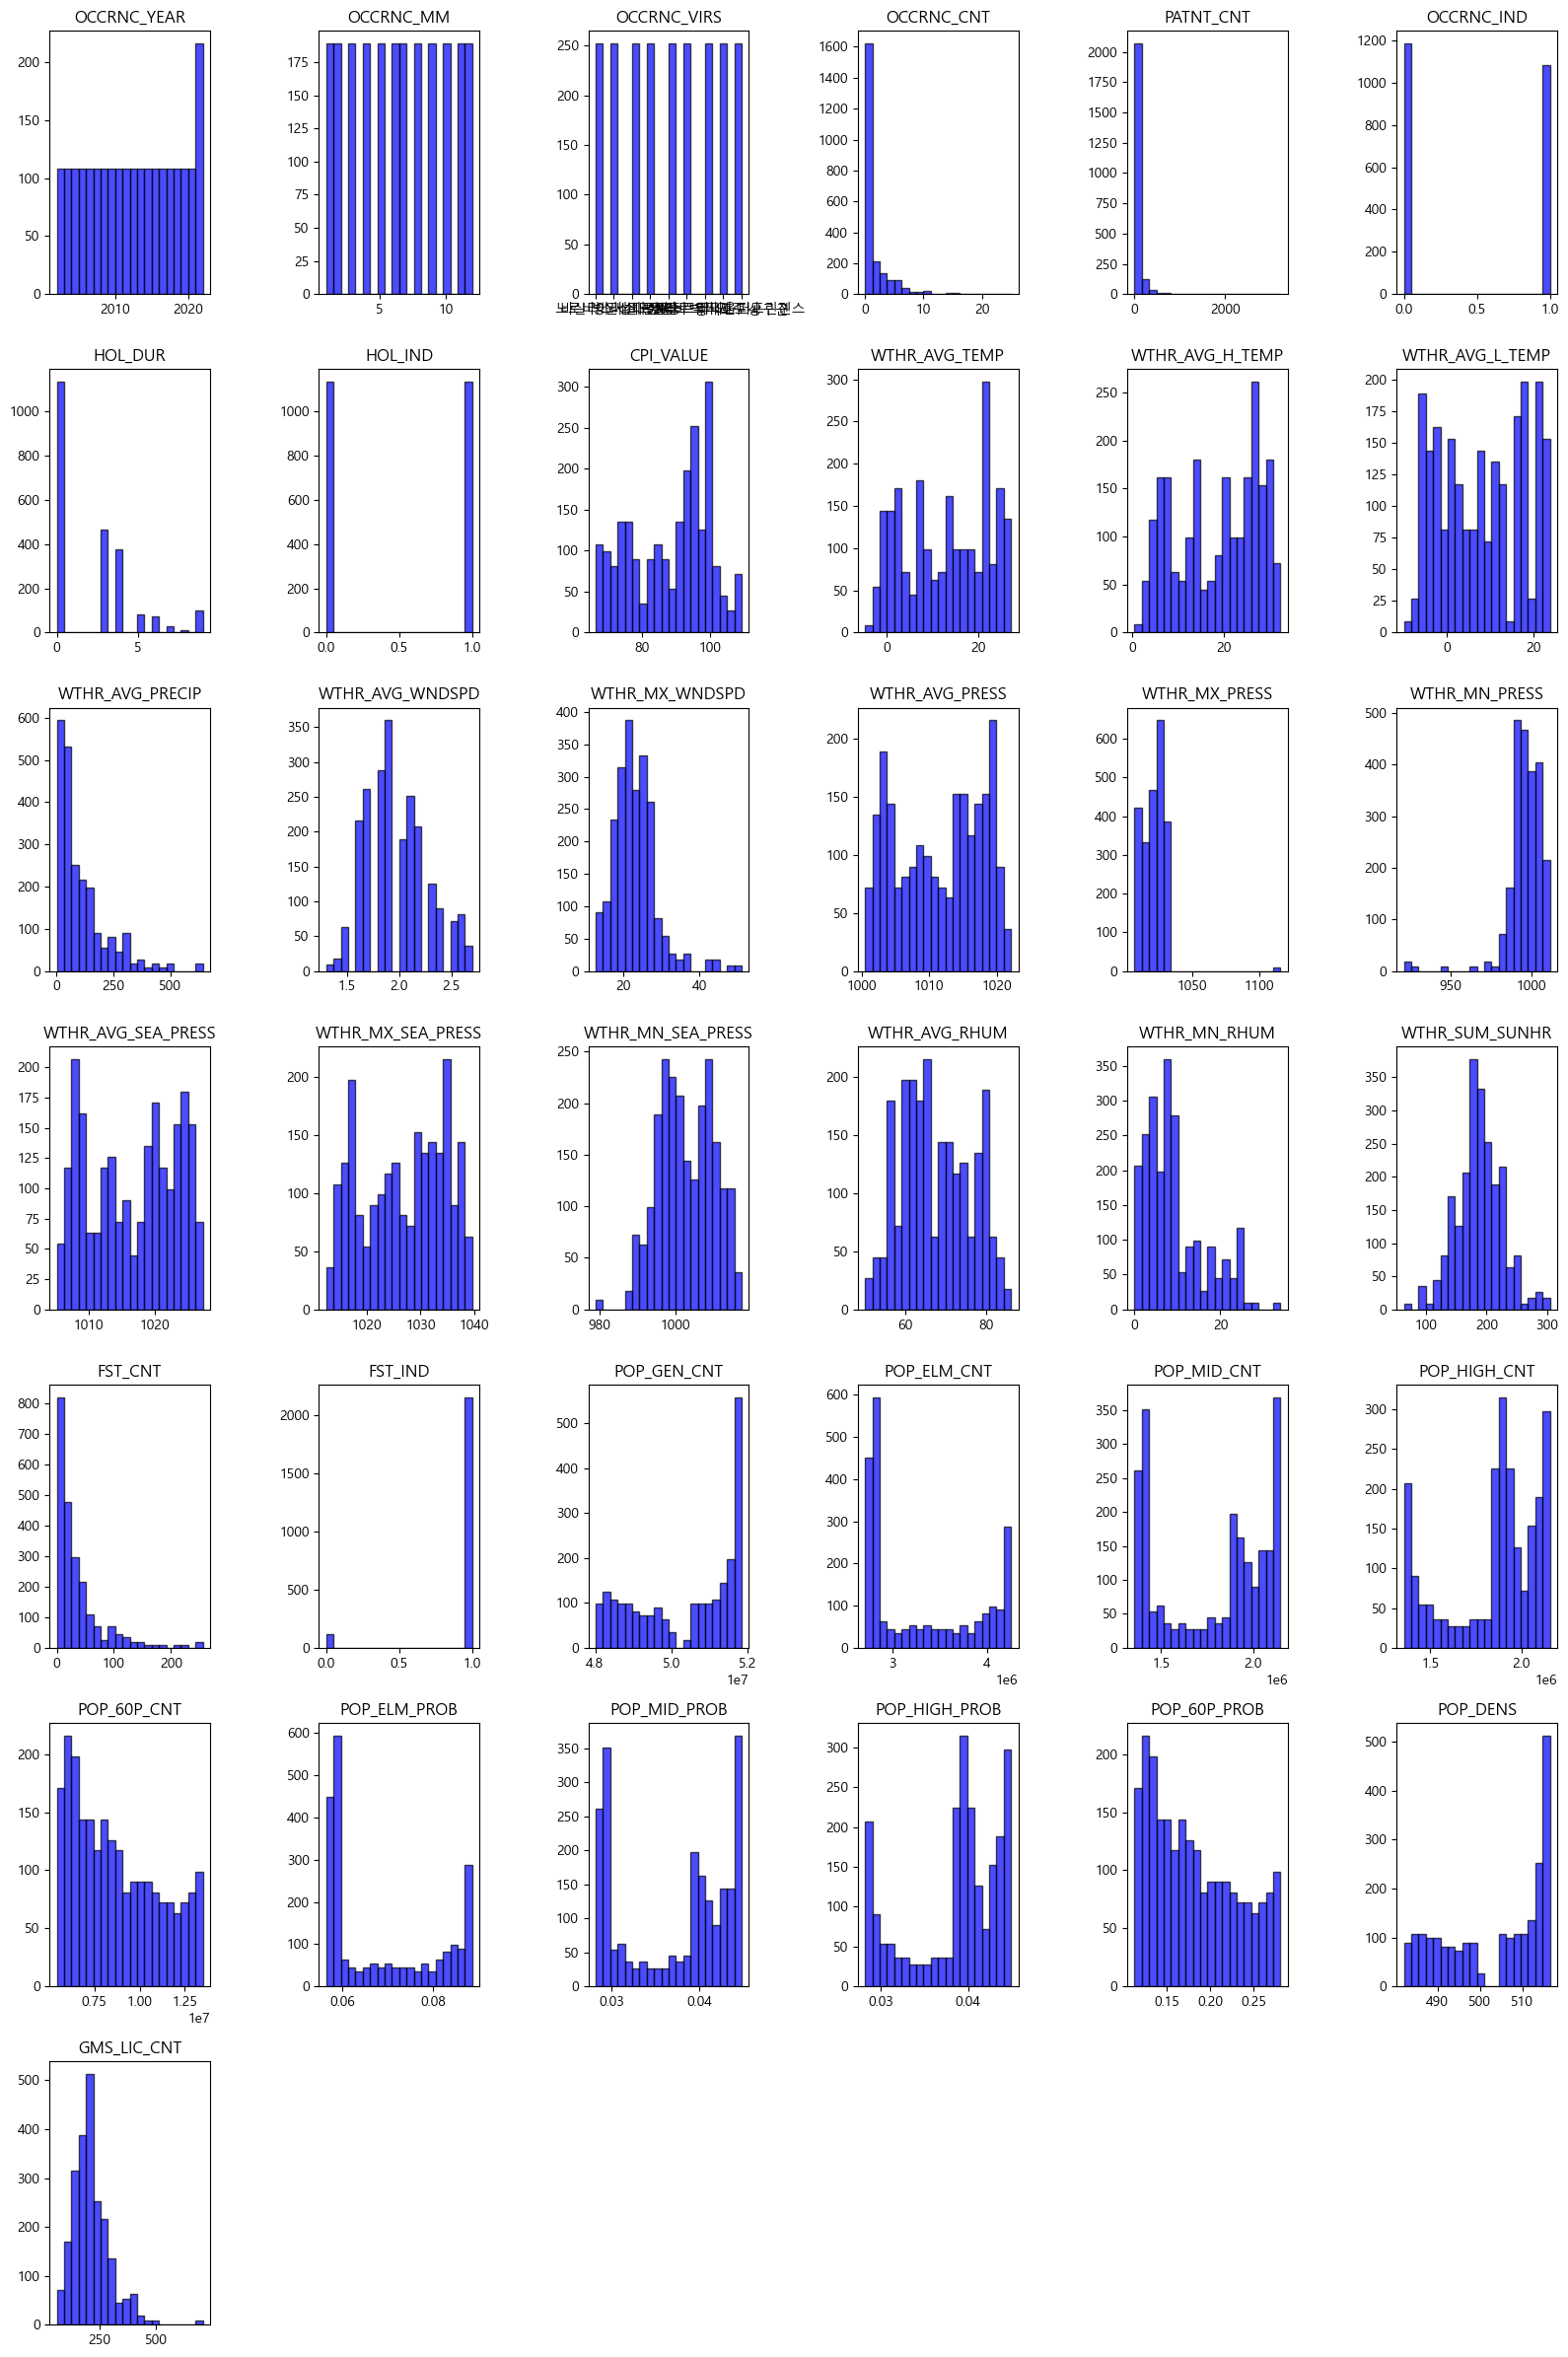

In [5]:
# 원인물질별 히스토그램
plt.figure(figsize=(16,24))
for i, col in enumerate(cause_df.columns,1):
    plt.subplot(7,6,i)
    plt.hist(cause_df[col].dropna(),bins=20,color= 'blue',edgecolor= 'black', alpha=0.7)
    plt.title(col)
plt.tight_layout()
plt.show()

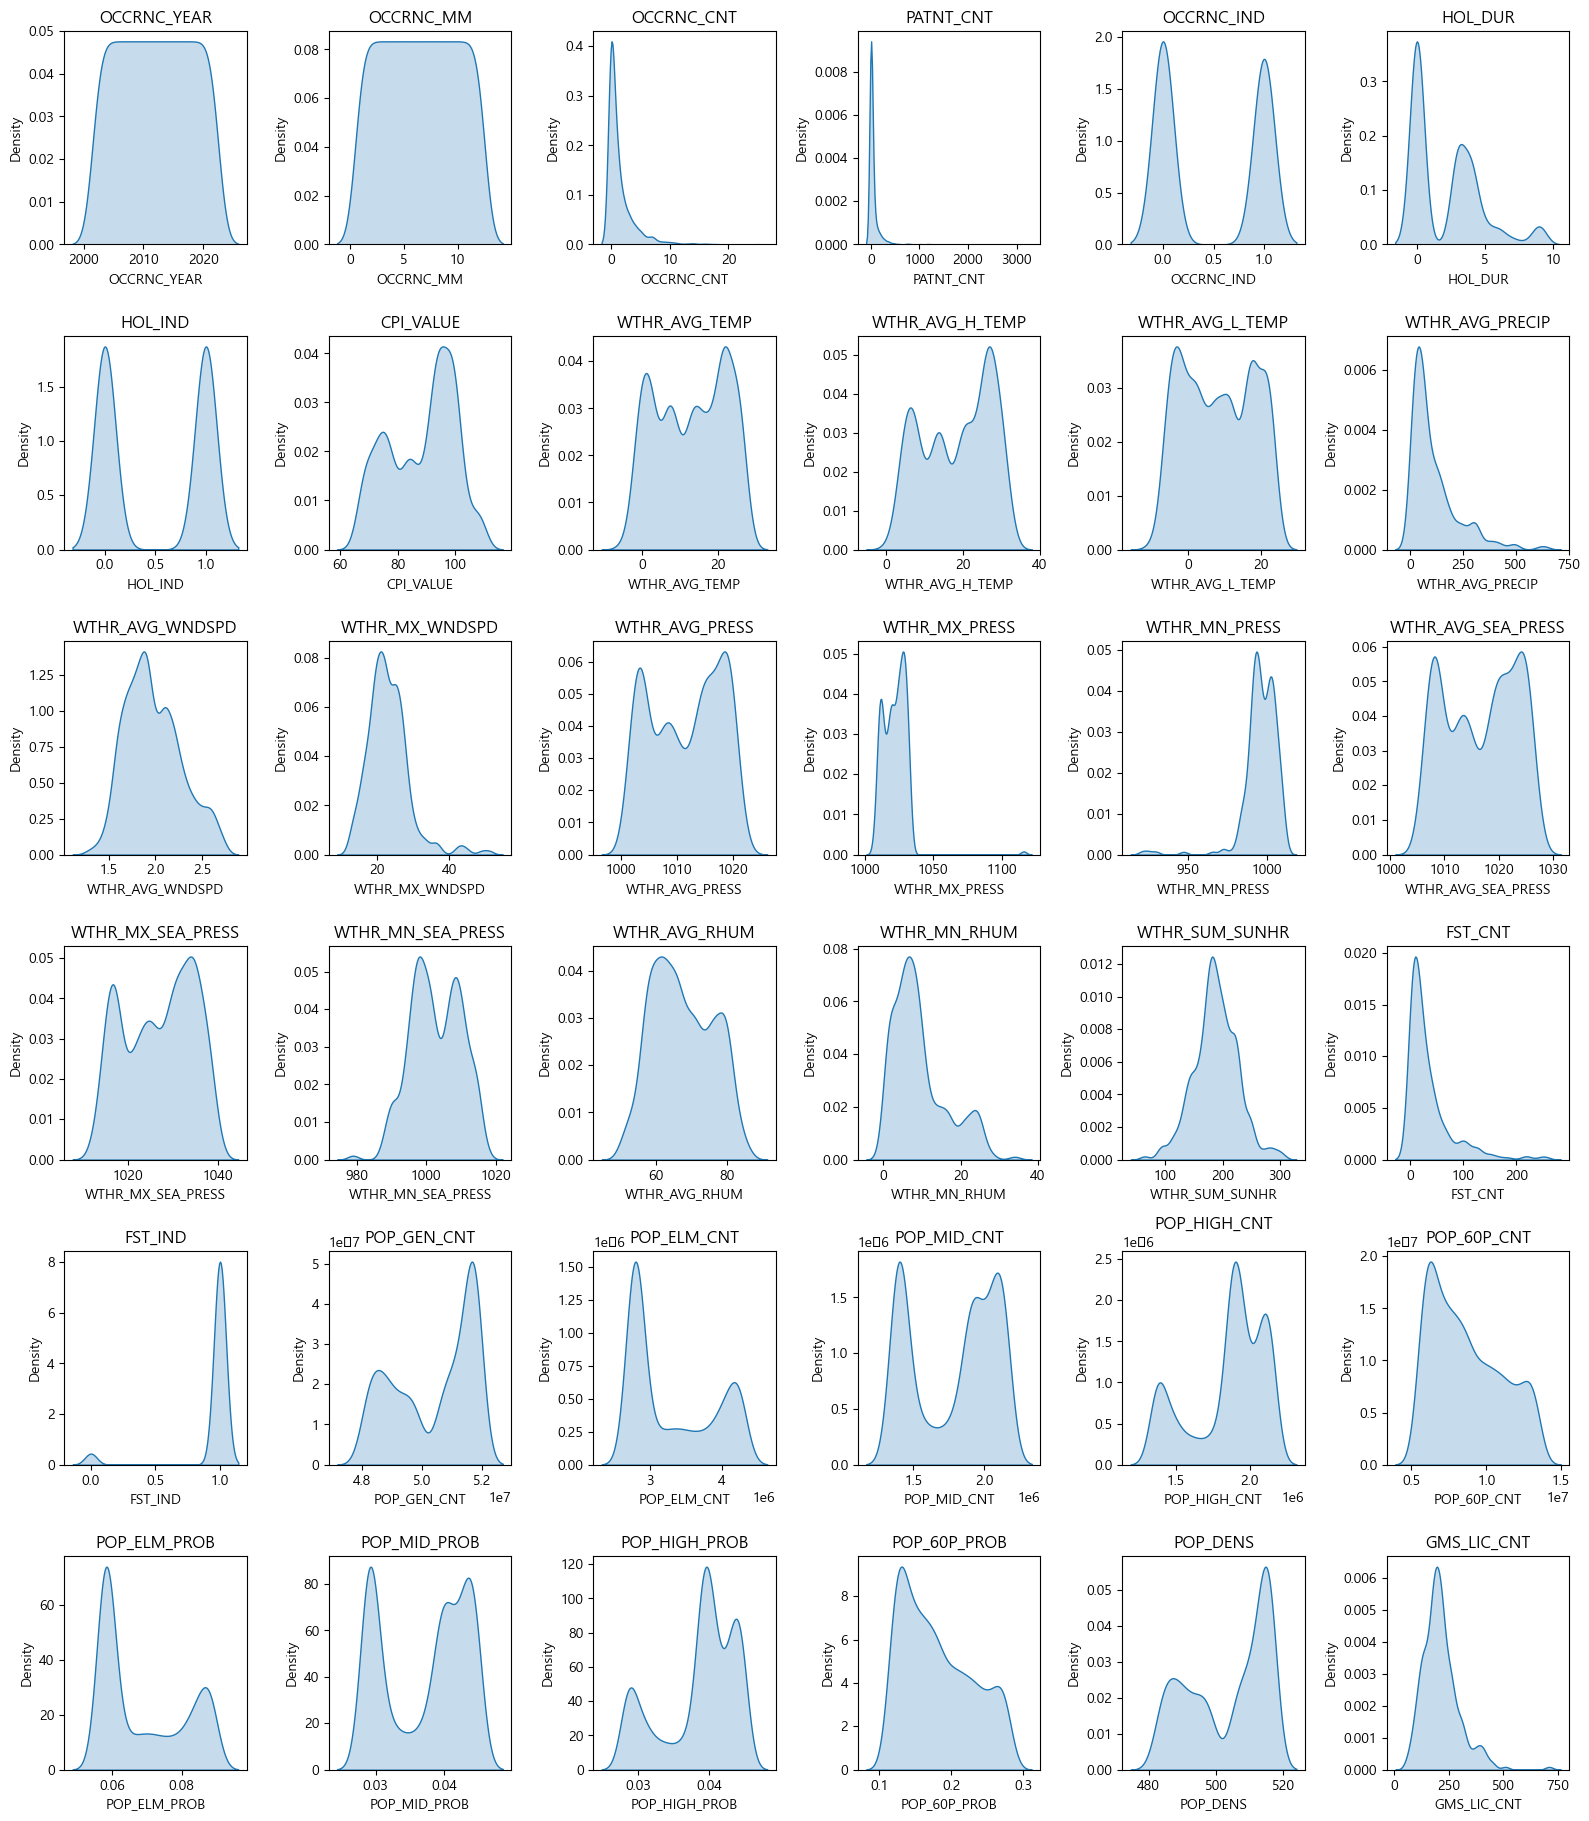

In [6]:
# 원인물질별 밀도그래프
numeric_cause_col = cause_df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(16,24))
for idx, col in enumerate(numeric_cause_col):
    if col in cause_df.columns:
        plt.subplot(8,6,idx+1)
        ax=sns.kdeplot(cause_df[col],shade=True)
        plt.title(f'{col}')
plt.tight_layout()
plt.show()

#### 2) 원인물질별 식중독 데이터 탐색

##### - 원인물질별 식중독 발생 건수 및 환자수

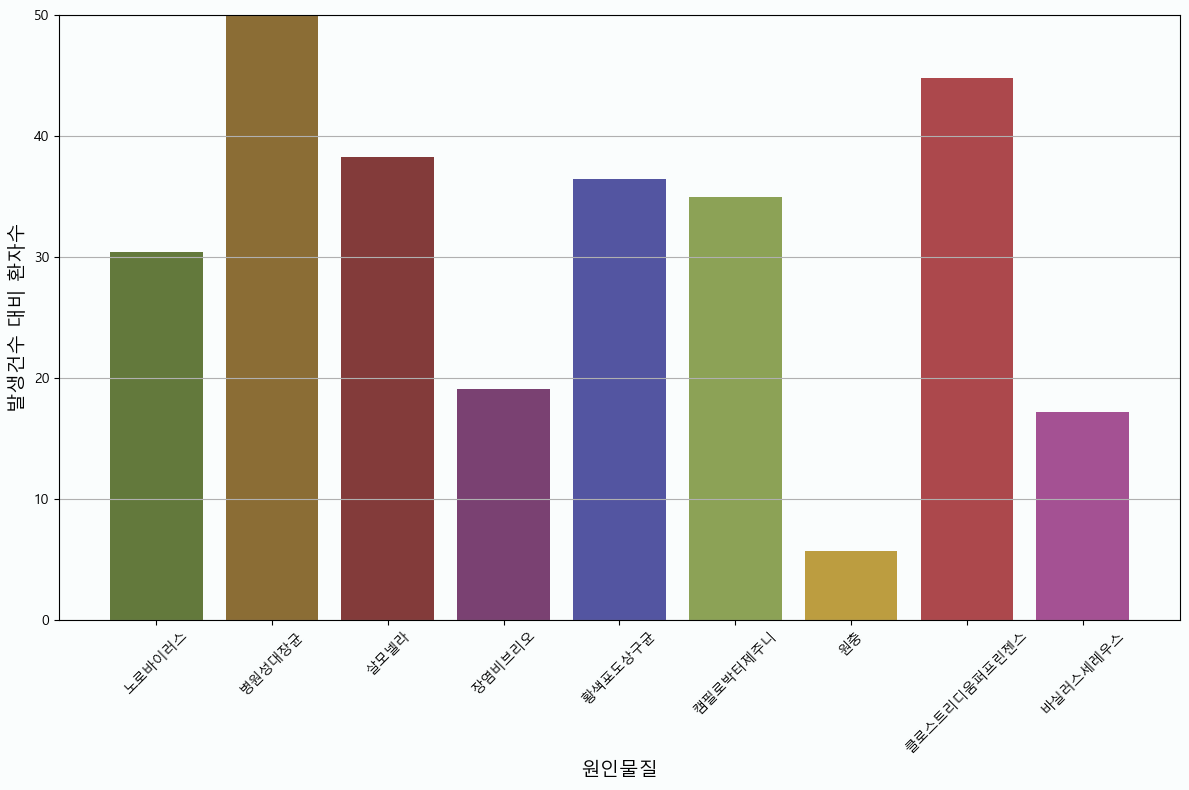

In [7]:
selected_pathogens = [
    '노로바이러스','병원성대장균','살모넬라','장염비브리오',
    '황색포도상구균','캠필로박터제주니','원충','클로스트리디움퍼프린젠스','바실러스세레우스'
    ] # 원인불명, 1% 미만 제외

# 원인물질별 발생 건수와 환자 수 집계
pathogen_summary = cause_df.groupby('OCCRNC_VIRS').agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
pathogen_summary['발생건수/환자수 비율'] = pathogen_summary['PATNT_CNT'] / pathogen_summary['OCCRNC_CNT']
filtered_pathogen_summary = pathogen_summary.loc[selected_pathogens]

colors = {
    '노로바이러스': '#63793C',
    '병원성대장균': '#8B6D35',
    '살모넬라': '#833B3A',
    '장염비브리오': '#7A4172',
    '황색포도상구균': '#5355A1',
    '캠필로박터제주니': '#8CA256',
    '원충': '#BC9D40',
    '클로스트리디움퍼프린젠스': '#AC484C',
    '바실러스세레우스': '#A45193'
}

plt.figure(figsize=(12, 8))
plt.gcf().patch.set_facecolor('#FAFDFD')

plt.bar(
    filtered_pathogen_summary.index,  # x축: 원인물질
    filtered_pathogen_summary['발생건수/환자수 비율'],  # y축: 발생건수 대비 환자수 비율
    color=[colors[pathogen] for pathogen in filtered_pathogen_summary.index]  # 각 항목별 색상 지정
)

# y축 범위와 tick 설정
plt.ylim(0, 50)  # y축 범위 설정
plt.yticks(range(0, 51, 10))  # y축 tick 단위 설정

# 그래프 안쪽 배경 색상 설정
plt.gca().set_facecolor('#FAFDFD')

#plt.title('Top7 원인물질별 발생 건수 대비 환자 수 비율')
plt.xlabel('원인물질', fontsize=14)
plt.ylabel('발생건수 대비 환자수', fontsize=14)
plt.xticks(rotation=45, ha='center')
plt.grid(axis='y')
plt.tight_layout()
plt.show()



##### - 월별 원인물질에 따른 식중독 발생 건수 추이

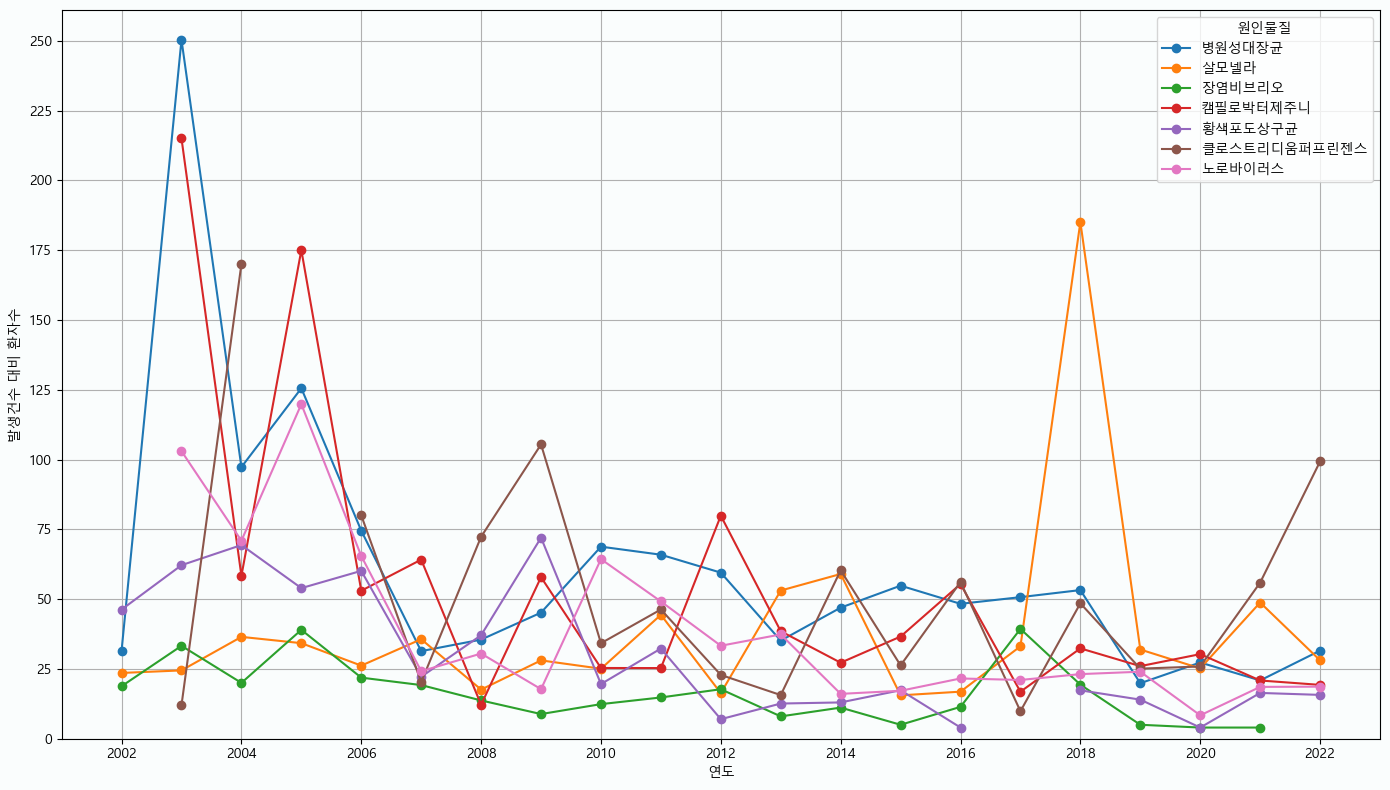

In [8]:
pathogen_list = ['병원성대장균', '살모넬라', '장염비브리오', '캠필로박터제주니', '황색포도상구균', '클로스트리디움퍼프린젠스', '노로바이러스']

# 연도별 원인물질별 발생 건수와 환자 수 집계
yearly_pathogen_summary = cause_df.groupby(['OCCRNC_YEAR', 'OCCRNC_VIRS']).agg({'OCCRNC_CNT': 'sum', 'PATNT_CNT': 'sum'})

# 발생 건수 대비 환자 수 비율 계산
yearly_pathogen_summary['발생건수/환자수 비율'] = yearly_pathogen_summary['PATNT_CNT'] / yearly_pathogen_summary['OCCRNC_CNT']

# 연도별 원인물질별 발생 건수 대비 환자 수 비율 변화 시각화
plt.figure(figsize=(14, 8))

# 그래프 외부 배경색 설정
plt.gcf().patch.set_facecolor('#FAFDFD')
# 그래프 내부 배경색 설정
ax = plt.gca()
ax.set_facecolor('#FAFDFD')

for pathogen in pathogen_list:
    plt.plot(yearly_pathogen_summary.loc[(slice(None), pathogen), :].index.get_level_values('OCCRNC_YEAR'),
            yearly_pathogen_summary.loc[(slice(None), pathogen), '발생건수/환자수 비율'],
            marker='o', label=pathogen)

plt.ylim(0, 261)  # y축 범위 설정
plt.yticks(range(0, 261, 25))  # y축 tick 단위 설정

plt.xlim(2001, 2023)  # x축 범위 설정
plt.xticks(range(2002, 2023, 2))  # x축 tick 단위 설정

#plt.title('연도별 원인물질별 발생 건수 대비 환자 수 비율 변화')
plt.xlabel('연도')
plt.ylabel('발생건수 대비 환자수')
plt.legend(title='원인물질')
plt.grid(True)
plt.tight_layout()
plt.show()

##### - 식중독 유발 순위 및 누적 비율

In [9]:
# 원인별 환자 수 및 발생 건수를 요약
cause_summary = cause_df.groupby('OCCRNC_VIRS')[['OCCRNC_CNT']].sum().sort_values(by='OCCRNC_CNT', ascending=False)

# 데이터 및 비율 계산
total_occurrences = cause_summary['OCCRNC_CNT'].sum()
cause_summary['percent'] = cause_summary['OCCRNC_CNT'] / total_occurrences * 100
cause_summary['cumulative_percent'] = cause_summary['percent'].cumsum()

cause_summary


,OCCRNC_CNT,percent,cumulative_percent
OCCRNC_VIRS,,,
노로바이러스,880,26.960784,26.960784
병원성대장균,678,20.772059,47.732843
살모넬라,475,14.552696,62.285539
장염비브리오,265,8.118873,70.404412
황색포도상구균,234,7.169118,77.573529
캠필로박터제주니,214,6.556373,84.129902
원충,196,6.004902,90.134804
클로스트리디움퍼프린젠스,191,5.851716,95.986520
바실러스세레우스,131,4.013480,100.000000


## 2. 모델 학습

### 1) 시계열 예측 및 원인물질별 최적 모델 정의

In [10]:
# 시계열 예측 함수 정의 (Prophet 사용)
def forecast_with_prophet(data, column, periods):
    df = data[['OCCRNC_YEAR', 'OCCRNC_MM', column]].copy()
    df['ds'] = pd.to_datetime(df['OCCRNC_YEAR'].astype(str) + '-' + df['OCCRNC_MM'].astype(str) + '-01', errors='coerce')
    
    if df['ds'].isna().any():
        raise ValueError(f"Date conversion failed for column {column}. Check your OCCRNC_YEAR and OCCRNC_MM values.")
    
    df['y'] = df[column]
    prophet_model = Prophet()
    prophet_model.fit(df[['ds', 'y']])
    
    future = prophet_model.make_future_dataframe(periods=periods, freq='M')
    forecast = prophet_model.predict(future)
    return forecast[['ds', 'yhat']]

# 2023년 예측에 사용할 feature 생성
forecasted_features = {}
periods_to_forecast = 12  # 12개월 예측

for column in cause_df.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT']).columns:
    forecast = forecast_with_prophet(cause_df, column, periods_to_forecast)
    forecasted_features[column] = forecast['yhat'].values

# 2023년 예측값만 추출
forecasted_2023_data = pd.DataFrame(forecasted_features)

# 원인물질별 최적 모델 정의
best_models_by_virus = {
    "노로바이러스": GradientBoostingClassifier(random_state=42),
    "바실러스세레우스": GradientBoostingClassifier(random_state=42),
    "병원성대장균": LGBMClassifier(objective='multiclass', random_state=42),
    "살모넬라": RandomForestClassifier(random_state=42),
    "원충": RandomForestClassifier(random_state=42),
    "장염비브리오": GradientBoostingClassifier(random_state=42),
    "캠필로박터제주니": GradientBoostingClassifier(random_state=42),
    "클로스트리디움퍼프린젠스": RandomForestClassifier(random_state=42),
    "황색포도상구균": RandomForestClassifier(random_state=42)
}

# 하이퍼파라미터 튜닝을 위한 그리드 정의
param_grids = {
    "RandomForestClassifier": {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    "GradientBoostingClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]},
    "XGBClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]},
    "LGBMClassifier": {'n_estimators': [100, 150], 'learning_rate': [0.1, 0.01]}
}

# 모델 학습 및 저장
thresholds_by_virus = {}

for virus, best_model in best_models_by_virus.items():
    # 데이터 준비
    virus_data = cause_df[cause_df['OCCRNC_VIRS'] == virus]
    X = virus_data.drop(columns=['OCCRNC_YEAR', 'OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_CNT', 'OCCRNC_IND', 'PATNT_CNT'])
    y = virus_data['OCCRNC_IND']

    # 타겟 변수 확인
    if y.nunique() < 2:
        print(f"Skipping {virus} due to single class in target variable.")
        continue

    # 데이터 분리
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # 데이터 불균형 처리 (병원성대장균만 SMOTE 사용)
    if virus == "병원성대장균":
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        best_model.set_params(num_class=y.nunique())  # LightGBM의 클래스 수 설정

    # 하이퍼파라미터 튜닝
    model_name = best_model.__class__.__name__
    best_params = {}

    if model_name in param_grids:
        # GridSearchCV로 하이퍼파라미터 최적화
        grid_search = GridSearchCV(best_model, param_grids[model_name], cv=3, scoring='recall_weighted', error_score='raise')
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{virus} - Best Params: {best_params}")
    else:
        # 하이퍼파라미터 최적화 없이 기본 모델 학습
        best_model.fit(X_train, y_train)

    # 모델 저장
    model_filename = f"{virus}_{best_model.__class__.__name__}.pkl"
    joblib.dump(best_model, model_filename)

    # 성능 평가 및 임계값 설정
    y_test_pred = best_model.predict(X_test)
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_test_pred),
        'Precision': precision_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_test_pred, average='weighted', zero_division=0),
        'F1 Score': f1_score(y_test, y_test_pred, average='weighted', zero_division=0)
    }
    print(f"{virus} - Test Metrics: {test_metrics}")

    # 임계값 설정: Precision-Recall Curve
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
        f1_scores = 2 * (precision * recall) / (precision + recall)
        optimal_threshold = thresholds[np.argmax(f1_scores)]  # F1 score가 최대인 임계값
        thresholds_by_virus[virus] = optimal_threshold
        print(f"{virus} - Optimal Threshold: {optimal_threshold}")
    else:
        print(f"{virus} does not support `predict_proba`. Skipping threshold optimization.")


11:28:14 - cmdstanpy - INFO - Chain [1] start processing
11:28:14 - cmdstanpy - INFO - Chain [1] done processing
11:28:14 - cmdstanpy - INFO - Chain [1] start processing
11:28:14 - cmdstanpy - INFO - Chain [1] done processing
11:28:15 - cmdstanpy - INFO - Chain [1] start processing
11:28:16 - cmdstanpy - INFO - Chain [1] done processing
11:28:16 - cmdstanpy - INFO - Chain [1] start processing
11:28:16 - cmdstanpy - INFO - Chain [1] done processing
11:28:16 - cmdstanpy - INFO - Chain [1] start processing
11:28:17 - cmdstanpy - INFO - Chain [1] done processing
11:28:17 - cmdstanpy - INFO - Chain [1] start processing
11:28:17 - cmdstanpy - INFO - Chain [1] done processing
11:28:17 - cmdstanpy - INFO - Chain [1] start processing
11:28:17 - cmdstanpy - INFO - Chain [1] done processing
11:28:18 - cmdstanpy - INFO - Chain [1] start processing
11:28:18 - cmdstanpy - INFO - Chain [1] done processing
11:28:18 - cmdstanpy - INFO - Chain [1] start processing
11:28:18 - cmdstanpy - INFO - Chain [1]

노로바이러스 - Best Params: {'learning_rate': 0.1, 'n_estimators': 150}
노로바이러스 - Test Metrics: {'Accuracy': 0.7894736842105263, 'Precision': 0.7741228070175438, 'Recall': 0.7894736842105263, 'F1 Score': 0.7701754385964912}
노로바이러스 - Optimal Threshold: 0.23375678610757586
바실러스세레우스 - Best Params: {'learning_rate': 0.1, 'n_estimators': 100}
바실러스세레우스 - Test Metrics: {'Accuracy': 0.75, 'Precision': 0.7534864643150122, 'Recall': 0.75, 'F1 Score': 0.7516095534787123}
바실러스세레우스 - Optimal Threshold: 0.4523224188917711
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1318
[LightGBM] [Info] Number of data points in the train set: 150, number of used features: 30
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Info] Start training from score -0.693147
[LightGBM] [Warning] No further sp

## 3. 2023년 식중독 발생 확률 예측

In [11]:
# 실제값 로드 및 예측값 생성
actual_2023_occurrences = actual_2023_data[['OCCRNC_MM', 'OCCRNC_VIRS', 'OCCRNC_IND']]

# 예측값 생성
predictions = []
virus_list = list(best_models_by_virus.keys())

### 1) 2023년 예측

In [12]:
# 모델 로드 및 예측 결과 저장

for virus in virus_list:
    # 모델 로드
    model_filename = f"D:\\project\\foodposion_project\\{virus}_{best_models_by_virus[virus].__class__.__name__}.pkl"
    model = joblib.load(model_filename)

    # 예측 데이터 준비
    virus_data = forecasted_2023_data.copy()
    virus_data['OCCRNC_VIRS'] = virus
    X_pred = virus_data.drop(columns=['OCCRNC_VIRS'])

    # 예측 수행
    y_pred_prob = model.predict_proba(X_pred)[:, 1]  # 예측 확률
    y_pred = (y_pred_prob > thresholds_by_virus[virus]).astype(int)

    # 예측 결과 저장
    for i, month in enumerate(range(1, 13)):
        predictions.append({'OCCRNC_MM': month, 'OCCRNC_VIRS': virus, 'Prediction': y_pred[i], 'Risk_Probability': y_pred_prob[i]})


In [13]:
# DataFrame 생성 및 비교
pred_cause_df = pd.DataFrame(predictions)

# 실제 데이터와 예측 데이터 병합
actual_2023_occurrences_unique = actual_2023_occurrences.pivot_table(
    index='OCCRNC_MM', columns='OCCRNC_VIRS', values='OCCRNC_IND'
).reset_index()

actual_2023_occurrences_unique = actual_2023_occurrences_unique.melt(
    id_vars=['OCCRNC_MM'], var_name='OCCRNC_VIRS', value_name='Actual'
)

comparison_df = pred_cause_df.merge(actual_2023_occurrences_unique, on=['OCCRNC_MM', 'OCCRNC_VIRS'], how='left')
comparison_df = comparison_df.dropna(subset=['Prediction', 'Actual'])


## 4. 모델 성능 계산

In [14]:
# 성능 지표 계산
accuracy = accuracy_score(comparison_df['Actual'], comparison_df['Prediction'])
precision = precision_score(comparison_df['Actual'], comparison_df['Prediction'], zero_division=0)
recall = recall_score(comparison_df['Actual'], comparison_df['Prediction'], zero_division=0)
f1 = f1_score(comparison_df['Actual'], comparison_df['Prediction'], zero_division=0)

# 결과 출력
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# 결과 저장
comparison_df.to_excel("2023_prediction_vs_actual_recall.xlsx", index=True)
comparison_df.to_csv("2023_prediction_warning.csv", index=True,encoding="utf-8-sig")

Accuracy: 0.49
Precision: 0.71
Recall: 0.23
F1 Score: 0.35


## 5. 결과 시각화

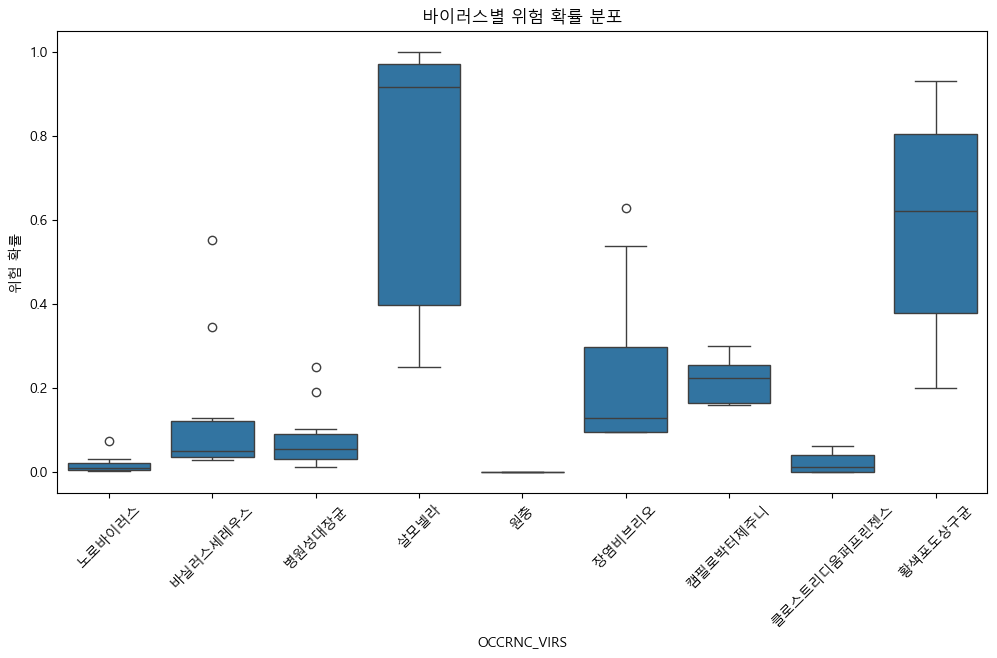

In [15]:
# 박스플롯
# 바이러스별 위험 확률 분포 시각화
plt.figure(figsize=(12, 6))
sns.boxplot(data=comparison_df, x='OCCRNC_VIRS', y='Risk_Probability')
plt.title("바이러스별 위험 확률 분포")
plt.xticks(rotation=45)
plt.ylabel("위험 확률")
plt.show()


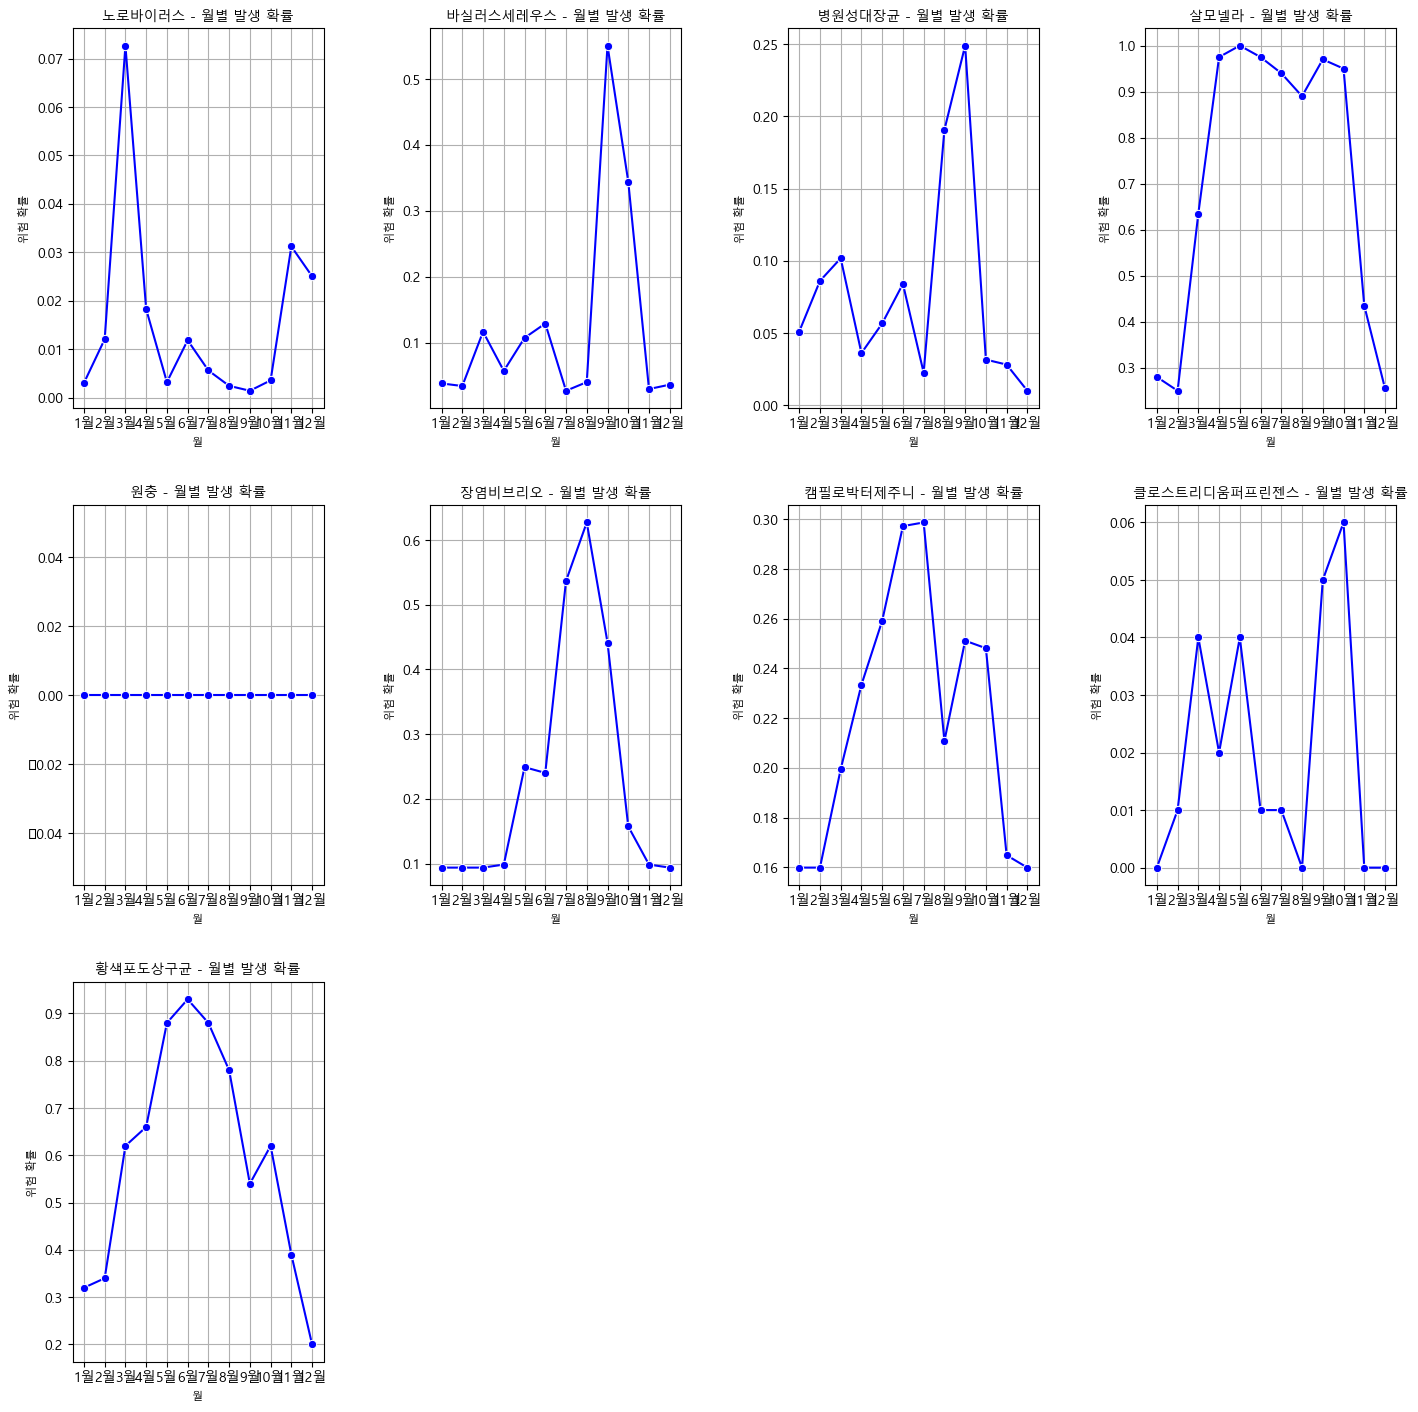

In [16]:
# 바이러스별 월별 발생 확률 계산
# 'comparison_df'에서 'OCCRNC_MM' (월), 'OCCRNC_VIRS' (바이러스), 'Risk_Probability' (위험 확률)을 사용하여 그래프를 그립니다.

# 고유한 바이러스 목록
viruses = comparison_df['OCCRNC_VIRS'].unique()

# 바이러스의 개수에 맞게 서브플롯 크기 설정
n_viruses = len(viruses)
ncols = 4  # 열 개수는 4로 고정
nrows = math.ceil(n_viruses / ncols)  # 행의 개수는 바이러스 개수에 맞춰 자동 계산

# 서브플롯을 그리기 위한 설정
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
fig.tight_layout(pad=5.0)

# 각 바이러스별로 월별 발생 확률을 그리기
for i, virus in enumerate(viruses):
    ax = axes[i // ncols, i % ncols]  # 4개의 열에 맞춰 서브플롯 위치 설정
    virus_data = comparison_df[comparison_df['OCCRNC_VIRS'] == virus]
    
    # 월별 위험 확률 평균 계산
    monthly_risk = virus_data.groupby('OCCRNC_MM')['Risk_Probability'].mean()

    # 시각화 (선 그래프)
    sns.lineplot(x=monthly_risk.index, y=monthly_risk.values, ax=ax, marker='o', color='b')
    
    ax.set_title(f'{virus} - 월별 발생 확률', fontsize=10)
    ax.set_xlabel('월', fontsize=8)
    ax.set_ylabel('위험 확률', fontsize=8)
    ax.set_xticks(range(1, 13))  # 월을 1부터 12까지 표시
    ax.set_xticklabels(['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'])
    ax.grid(True)

# 여분의 서브플롯 비워두기 (바이러스가 적을 경우 남는 영역 비워두기)
for i in range(n_viruses, nrows * ncols):
    fig.delaxes(axes[i // ncols, i % ncols])

plt.show()

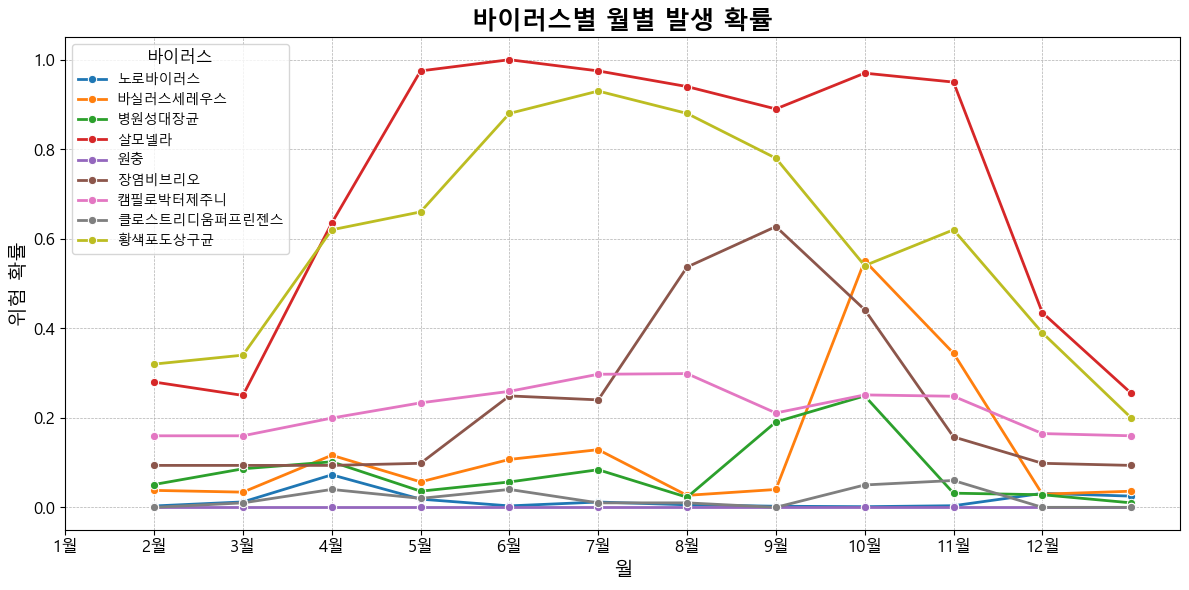

In [17]:
# 바이러스별 월별 발생 확률 계산
viruses = comparison_df['OCCRNC_VIRS'].unique()

# 그래프 설정
plt.figure(figsize=(12, 6))

# 각 바이러스별로 월별 발생 확률을 그리기
for virus in viruses:
    virus_data = comparison_df[comparison_df['OCCRNC_VIRS'] == virus]
    
    # 월별 위험 확률 평균 계산
    monthly_risk = virus_data.groupby('OCCRNC_MM')['Risk_Probability'].mean()

    # 선 그래프 추가
    sns.lineplot(x=monthly_risk.index, y=monthly_risk.values, label=virus, marker='o', linewidth=2)

# 그래프 제목 및 레이블 설정
plt.title('바이러스별 월별 발생 확률', fontsize=18, fontweight='bold')
plt.xlabel('월', fontsize=14)
plt.ylabel('위험 확률', fontsize=14)

# x축 레이블 수정
plt.xticks(range(12), ['1월', '2월', '3월', '4월', '5월', '6월', '7월', '8월', '9월', '10월', '11월', '12월'], fontsize=12)

# y축 레이블 폰트 크기 수정
plt.yticks(fontsize=12)

# 범례 위치 및 크기 조정
plt.legend(title='바이러스', loc='upper left', fontsize=10, title_fontsize=12)

# 격자선 추가
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# 그래프 출력
plt.tight_layout()
plt.show()


## 6. 모델 성능 시각화

In [18]:
print(comparison_df.columns)

Index(['OCCRNC_MM', 'OCCRNC_VIRS', 'Prediction', 'Risk_Probability', 'Actual'], dtype='object')


In [19]:
comparison_df

,OCCRNC_MM,OCCRNC_VIRS,Prediction,Risk_Probability,Actual
0,1,노로바이러스,0,0.003069,1.0
1,2,노로바이러스,0,0.012094,1.0
2,3,노로바이러스,0,0.072663,1.0
3,4,노로바이러스,0,0.018304,1.0
4,5,노로바이러스,0,0.003246,1.0
...,...,...,...,...,...
103,8,황색포도상구균,1,0.780000,1.0
104,9,황색포도상구균,1,0.540000,1.0
105,10,황색포도상구균,1,0.620000,1.0
106,11,황색포도상구균,1,0.390000,1.0


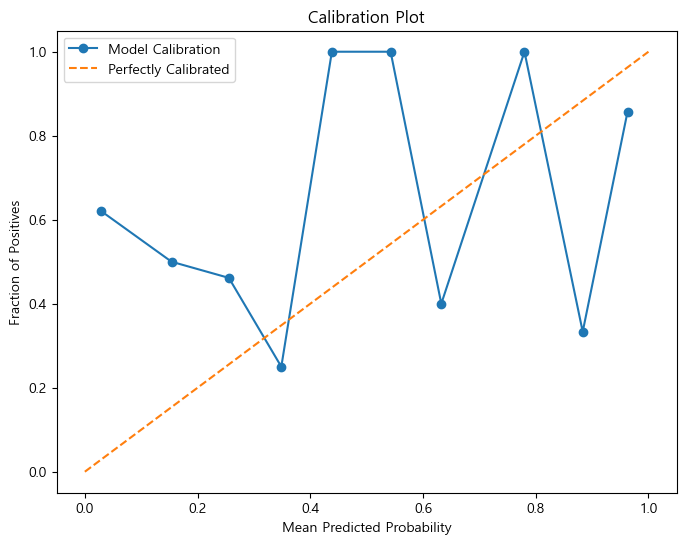

In [20]:
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

# 'Risk_Probability'와 'Actual' 데이터를 사용
y_true = comparison_df['Actual']  # 실제값
y_prob = comparison_df['Risk_Probability']  # 모델 예측 확률

# Calibration Curve 계산
fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob, n_bins=10)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Model Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')  # 완벽히 교정된 경우
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot')
plt.legend(loc='best')
plt.show()


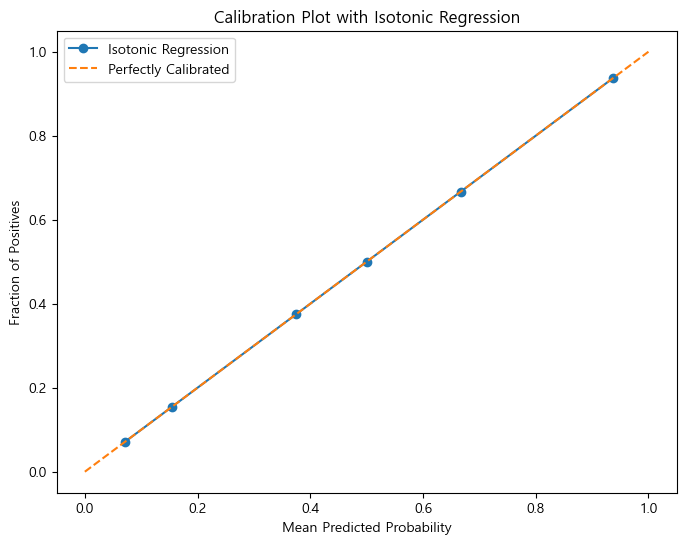

In [21]:
from sklearn.calibration import CalibratedClassifierCV, IsotonicRegression

# Isotonic Regression으로 모델 교정하기
calibrated_model_isotonic = CalibratedClassifierCV(model, method='isotonic', cv='prefit')
calibrated_model_isotonic.fit(X_test, y_test)

# 교정된 예측 확률 얻기
y_prob_calibrated_isotonic = calibrated_model_isotonic.predict_proba(X_test)[:, 1]

# Calibration Plot을 그리기
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_prob_calibrated_isotonic, n_bins=10)

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Isotonic Regression')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Plot with Isotonic Regression')
plt.legend(loc='best')
plt.show()


Isotonic Regression을 사용한 교정 후, Calibration plot를 다시 그림

In [22]:
from sklearn.isotonic import IsotonicRegression

# Isotonic Regression을 사용하여 교정된 확률을 계산
iso_reg = IsotonicRegression(out_of_bounds='clip')  
iso_reg.fit(comparison_df['Risk_Probability'], comparison_df['Actual'])  # 원래 확률과 실제값 사용
calibrated_probs = iso_reg.predict(comparison_df['Risk_Probability'])  # 교정된 확률 예측

# 결과를 새로운 DataFrame으로 저장
results_df = pd.DataFrame({
    'OCCRNC_MM': comparison_df['OCCRNC_MM'],
    'OCCRNC_VIRS': comparison_df['OCCRNC_VIRS'],
    'Original_Probability': comparison_df['Risk_Probability'],  # 원래 예측 확률
    'Calibrated_Probability': np.round(calibrated_probs, 3),  # 교정된 확률
    'Actual': comparison_df['Actual']  # 실제값
})

# 결과 출력
print("원래 예측 확률과 교정된 확률 비교:")
print(results_df)

# CSV 파일로 저장 (선택 사항)
results_df.to_csv("calibrated_risk_probabilities.csv", index=False)

원래 예측 확률과 교정된 확률 비교:
     OCCRNC_MM OCCRNC_VIRS  Original_Probability  Calibrated_Probability  \
0            1      노로바이러스              0.003069                   0.574   
1            2      노로바이러스              0.012094                   0.574   
2            3      노로바이러스              0.072663                   0.574   
3            4      노로바이러스              0.018304                   0.574   
4            5      노로바이러스              0.003246                   0.574   
..         ...         ...                   ...                     ...   
103          8     황색포도상구균              0.780000                   0.643   
104          9     황색포도상구균              0.540000                   0.643   
105         10     황색포도상구균              0.620000                   0.643   
106         11     황색포도상구균              0.390000                   0.643   
107         12     황색포도상구균              0.200000                   0.574   

     Actual  
0       1.0  
1       1.0  
2       1.0  
3       1.

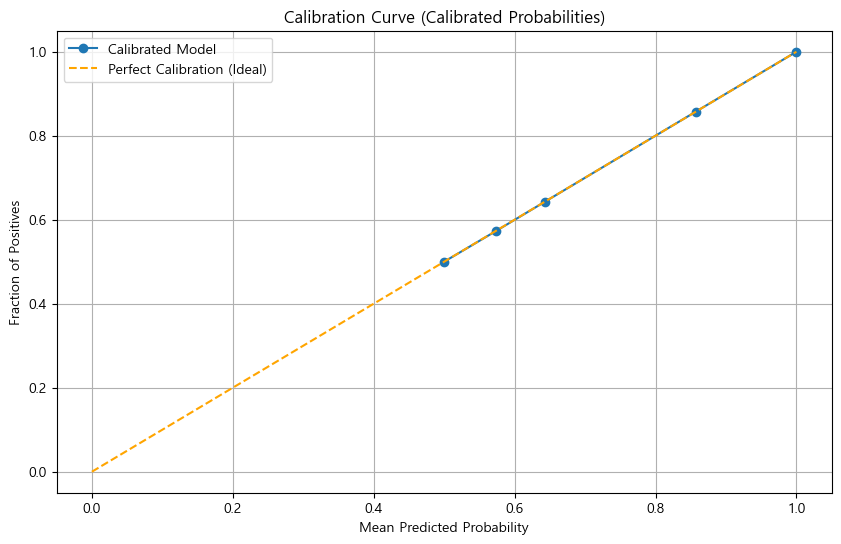

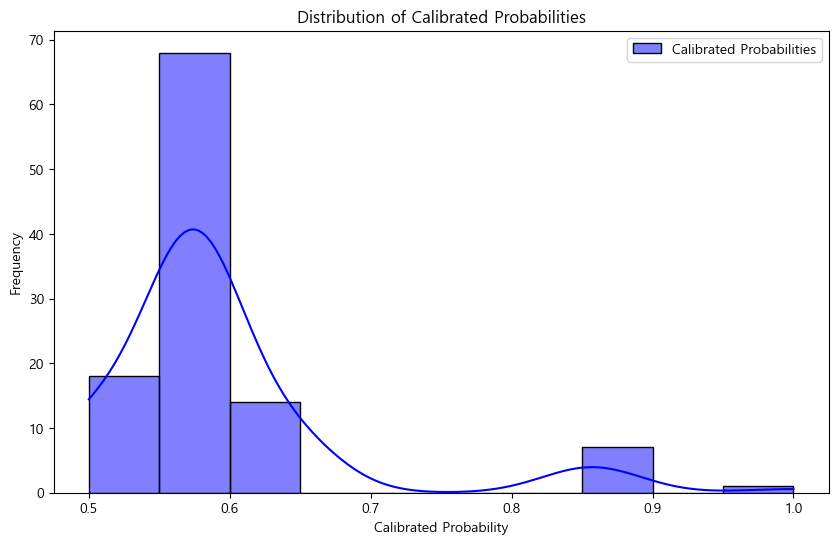

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.calibration import calibration_curve

# 교정된 확률과 실제값 불러오기
y_true = results_df['Actual']  # 실제값
y_prob_calibrated = results_df['Calibrated_Probability']  # 교정된 확률

# Calibration Curve 계산
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_true, y_prob_calibrated, n_bins=10, strategy='uniform'
)

# 시각화: Calibration Curve
plt.figure(figsize=(10, 6))

# Calibration Curve 그리기
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Calibrated Model', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration (Ideal)', color='orange')

# 그래프 설정
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve (Calibrated Probabilities)')
plt.legend()
plt.grid(True)
plt.show()

# 교정된 확률 분포 확인
plt.figure(figsize=(10, 6))
sns.histplot(y_prob_calibrated, bins=10, kde=True, color='blue', label='Calibrated Probabilities')
plt.xlabel('Calibrated Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Calibrated Probabilities')
plt.legend()
plt.show()
